## Setup autoreload, warnings and helper functions

In [19]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set the visibility of cuda devices (in case your system contains more than one)

In [20]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


## Imports

In [52]:
%matplotlib inline
from config import config
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import zipfile
import tensorflow as tf
import wget
import pickle
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from torchvision.datasets.utils import download_url
from datasets import SimpleDataset

from tools import apply_pipeline, crop_step, curry, apply_pipeline_cocodataset, get_save_step
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from reidentification.identify import encode_single, encode_pipeline, create_database, identify, identify_single, encode_dataset
from reidentification.visualisation import visualise_match
from simple_database import DBDatabase

## Create a configuration file.
You can change the default parameters in config.py

In [53]:
cfg = config()

/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:71: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.9)
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:73: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
/ekaterina/env/norppa/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Path to the dataset

In [54]:
cfg["dataset_dir"] = "/ekaterina/work/data/dataset-0520/segmented/query"
cfg["dataset_db_dir"] = "/ekaterina/work/data/dataset-0520/segmented/database"

dataset_dir = Path(cfg["dataset_dir"])
dataset_db_dir = Path(cfg["dataset_db_dir"])

print(f'SealID dataset is ready')

SealID dataset is ready


## Create dataset variables

In [55]:
query_dataset = SimpleDataset(dataset_dir)

print(len(query_dataset))

img_data = query_dataset[3]
print(img_data)

1650
(<PIL.Image.Image image mode=RGB size=1501x593 at 0x7F0ABCF8C910>, {'class_id': 'phs026', 'file': '/ekaterina/work/data/dataset-0520/segmented/query/phs026/IM000306.JPG.result.png', 'dataset_dir': PosixPath('/ekaterina/work/data/dataset-0520/segmented/query')})


## Show an image from the dataset

# Input image

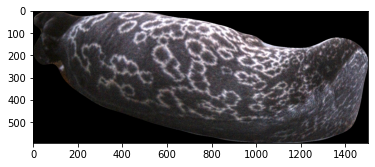

In [56]:
img, label = img_data

print_heading("Input image")
plt.imshow(img)
plt.show()

## Extract pattern

In [66]:
extract_pattern_step = curry(extract_pattern, model=cfg["unet"])
pattern_query_dataset = apply_pipeline_cocodataset(query_dataset, [crop_step,extract_pattern_step], verbose=True)

Completed 1/1650 images
Completed 2/1650 images
Completed 3/1650 images
Completed 4/1650 images
Completed 5/1650 images
Completed 6/1650 images
Completed 7/1650 images
Completed 8/1650 images
Completed 9/1650 images
Completed 10/1650 images
Completed 11/1650 images
Completed 12/1650 images
Completed 13/1650 images
Completed 14/1650 images
Completed 15/1650 images
Completed 16/1650 images
Completed 17/1650 images
Completed 18/1650 images
Completed 19/1650 images
Completed 20/1650 images
Completed 21/1650 images
Completed 22/1650 images
Completed 23/1650 images
Completed 24/1650 images
Completed 25/1650 images
Completed 26/1650 images
Completed 27/1650 images
Completed 28/1650 images
Completed 29/1650 images
Completed 30/1650 images
Completed 31/1650 images
Completed 32/1650 images
Completed 33/1650 images
Completed 34/1650 images
Completed 35/1650 images
Completed 36/1650 images
Completed 37/1650 images
Completed 38/1650 images
Completed 39/1650 images
Completed 40/1650 images
Completed

## Encode dataset

In [67]:
encoded_dataset = encode_dataset(pattern_query_dataset, cfg)
print(len(encoded_dataset))
print("Encoded dataset")

  0%|                                                  | 0/1650 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|███████████████████████████████████████| 1650/1650 [39:36<00:00,  1.44s/it]


Calculating PCA
Getting encoding parameters...
Encoding...
1650
Encoded dataset


## Save intermediate steps id needed

In [ ]:

with open("temp/files/encoded_sealid_full.pickle", 'wb') as f_file:
    pickle.dump(encoded_dataset, f_file)

In [ ]:

with open("temp/files/encoded_sealid_full.pickle", 'rb') as f_file:
    encoded_dataset = pickle.load(f_file)

In [78]:
with open("temp/files/encoded_sealid.pickle", 'rb') as f_file:
    correct = pickle.load(f_file)

## Load database for testing
This example uses a very simple database implemented as a Python class. 

In [81]:
# db_database = DBDatabase("norppa", cfg)

db_dataset = SimpleDataset(dataset_db_dir)
pattern_db_dataset = apply_pipeline_cocodataset(db_dataset, [crop_step,extract_pattern_step], verbose=True)
db_database = encode_dataset(pattern_db_dataset, cfg)

# print(len(db_database.get_fisher_vectors()))
print(len(db_database))
print("Created a test database")

Completed 1/430 images
Completed 2/430 images
Completed 3/430 images
Completed 4/430 images
Completed 5/430 images
Completed 6/430 images
Completed 7/430 images
Completed 8/430 images
Completed 9/430 images
Completed 10/430 images
Completed 11/430 images
Completed 12/430 images
Completed 13/430 images
Completed 14/430 images
Completed 15/430 images
Completed 16/430 images
Completed 17/430 images
Completed 18/430 images
Completed 19/430 images
Completed 20/430 images
Completed 21/430 images
Completed 22/430 images
Completed 23/430 images
Completed 24/430 images
Completed 25/430 images
Completed 26/430 images
Completed 27/430 images
Completed 28/430 images
Completed 29/430 images
Completed 30/430 images
Completed 31/430 images
Completed 32/430 images
Completed 33/430 images
Completed 34/430 images
Completed 35/430 images
Completed 36/430 images
Completed 37/430 images
Completed 38/430 images
Completed 39/430 images
Completed 40/430 images
Completed 41/430 images
Completed 42/430 images
C

  0%|                                                   | 0/430 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|█████████████████████████████████████████| 430/430 [10:44<00:00,  1.50s/it]


Calculating PCA
Getting encoding parameters...
Encoding...
430
Created a test database


## Perform re-identification

In [84]:
identification_result = identify(encoded_dataset, db_database, cfg)

100%|███████████████████████████████████████| 1650/1650 [02:12<00:00, 12.45it/s]


## Calculate the accuracy

In [85]:
db_labels = np.array([[x['db_label']['class_id'] for x in y[0]] for y in identification_result])
print(db_labels)
q_labels = np.array(query_dataset.get_labels())

print(len(q_labels))


topk = 5

hits = (db_labels.T == q_labels).T
print([sum((np.sum(hits[:, :j+1], axis=1) > 0)) / len(q_labels)
        for j in range(topk)])

[['phs026' 'phs026' 'phs230' 'phs082' 'phs130']
 ['phs130' 'phs026' 'phs101' 'phs026' 'phs026']
 ['phs026' 'phs026' 'phs130' 'phs100' 'phs088']
 ...
 ['phs219' 'phs219' 'phs219' 'phs109' 'phs223']
 ['phs219' 'phs219' 'phs223' 'phs096' 'phs080']
 ['phs219' 'phs096' 'phs223' 'phs137' 'phs149']]
1650
[0.7727272727272727, 0.8078787878787879, 0.8224242424242424, 0.8363636363636363, 0.850909090909091]


## Visualise re-identification results

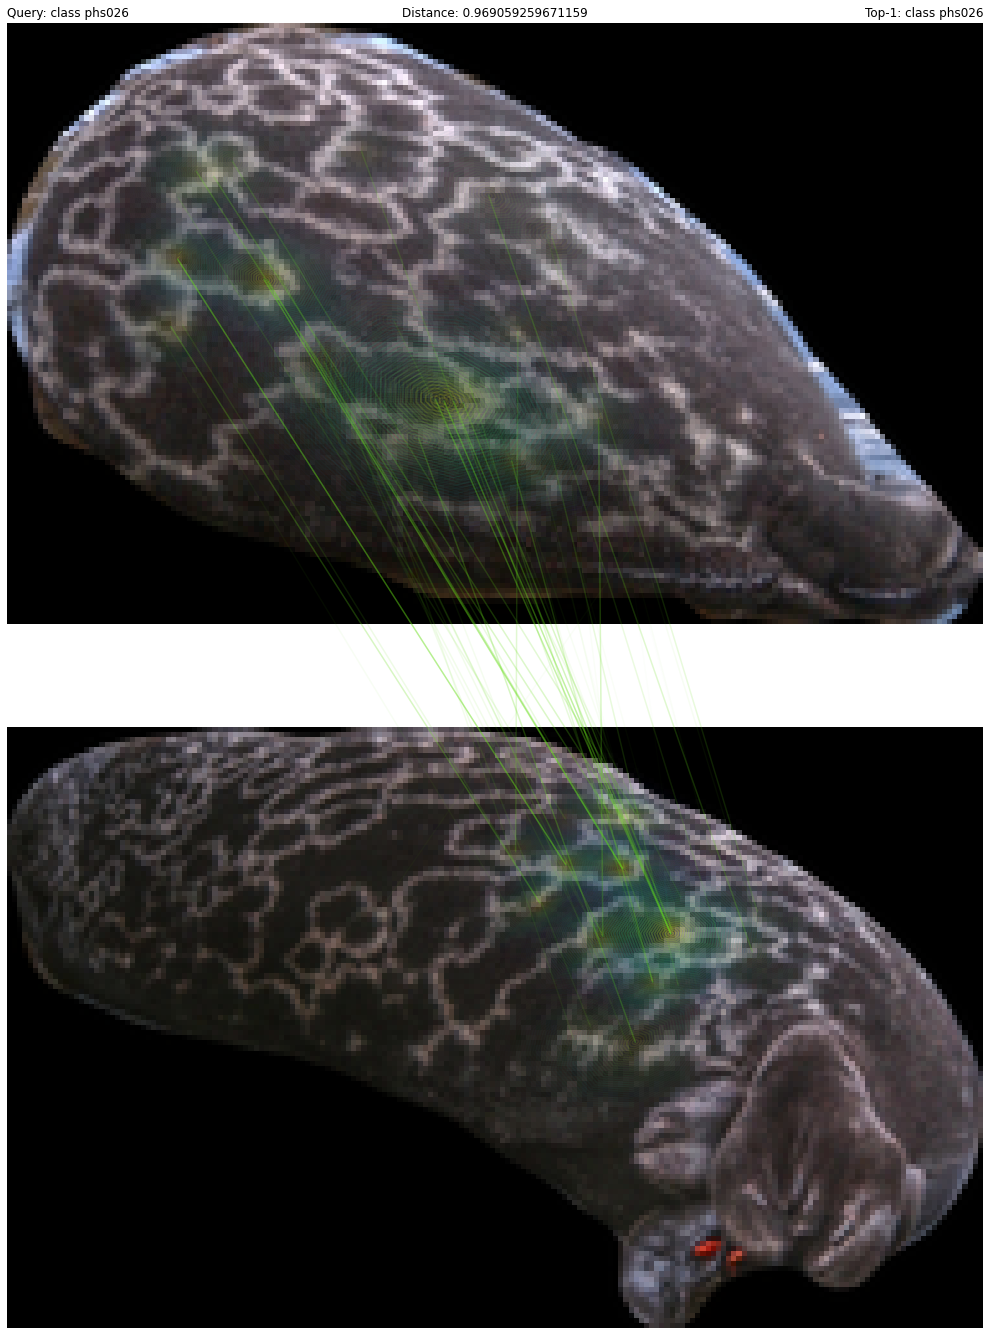

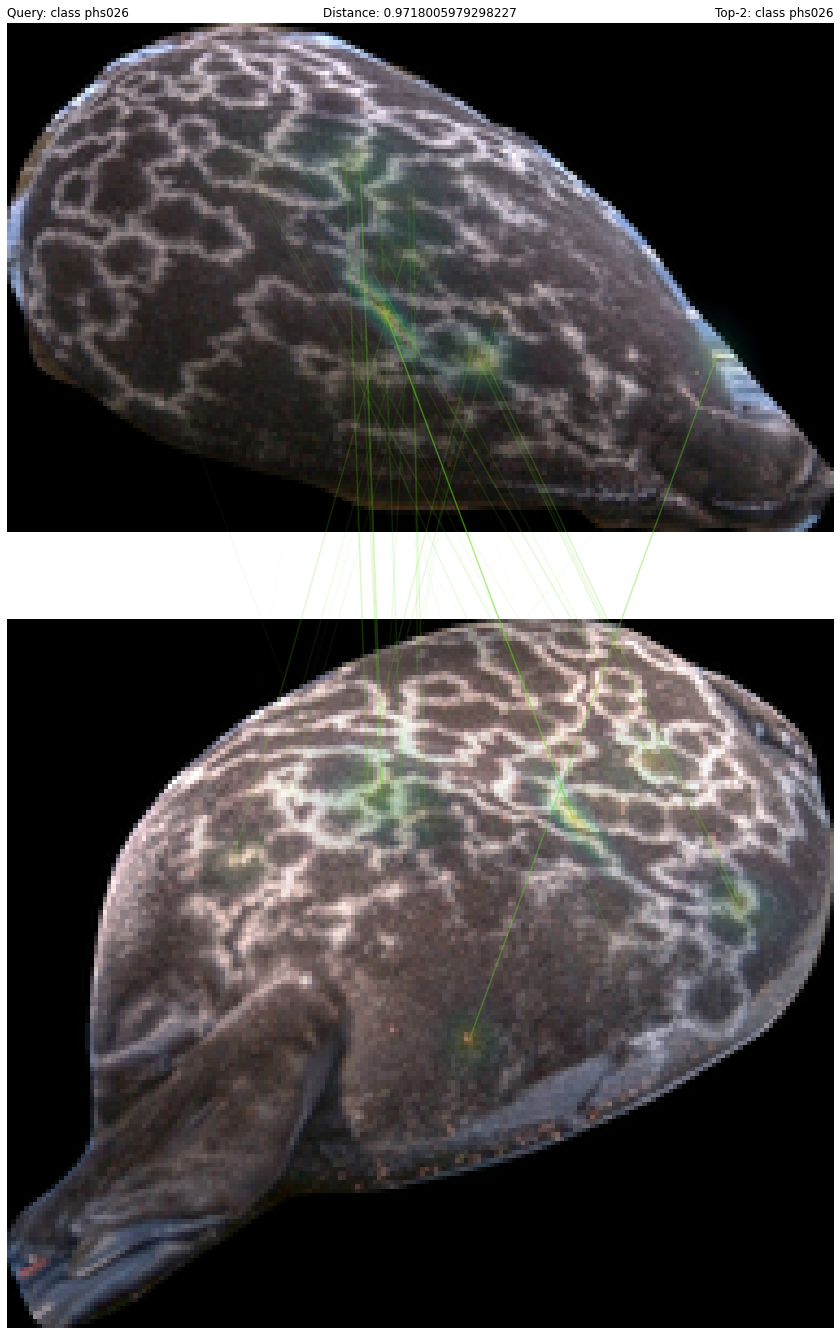

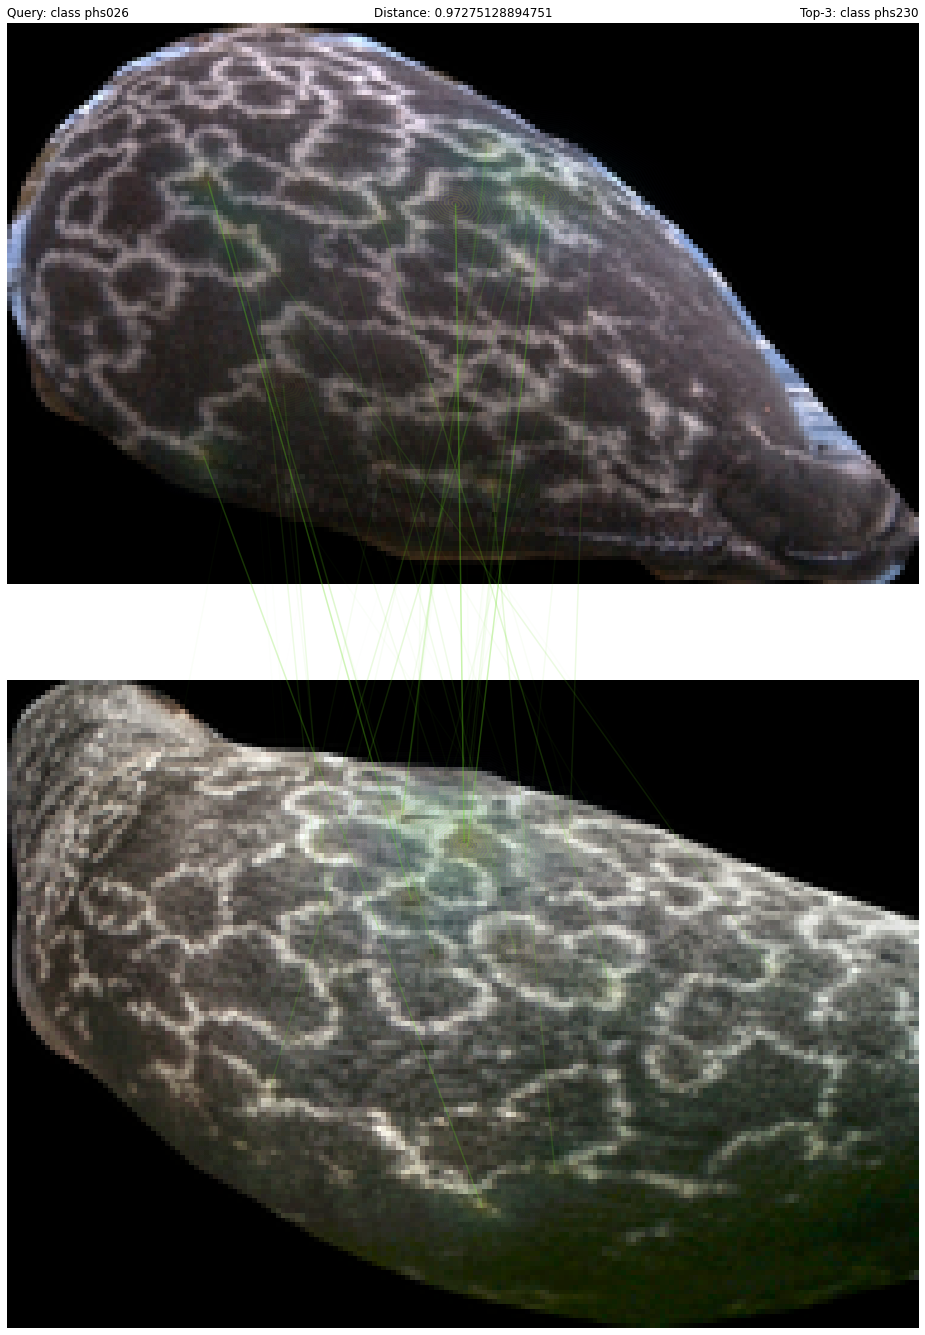

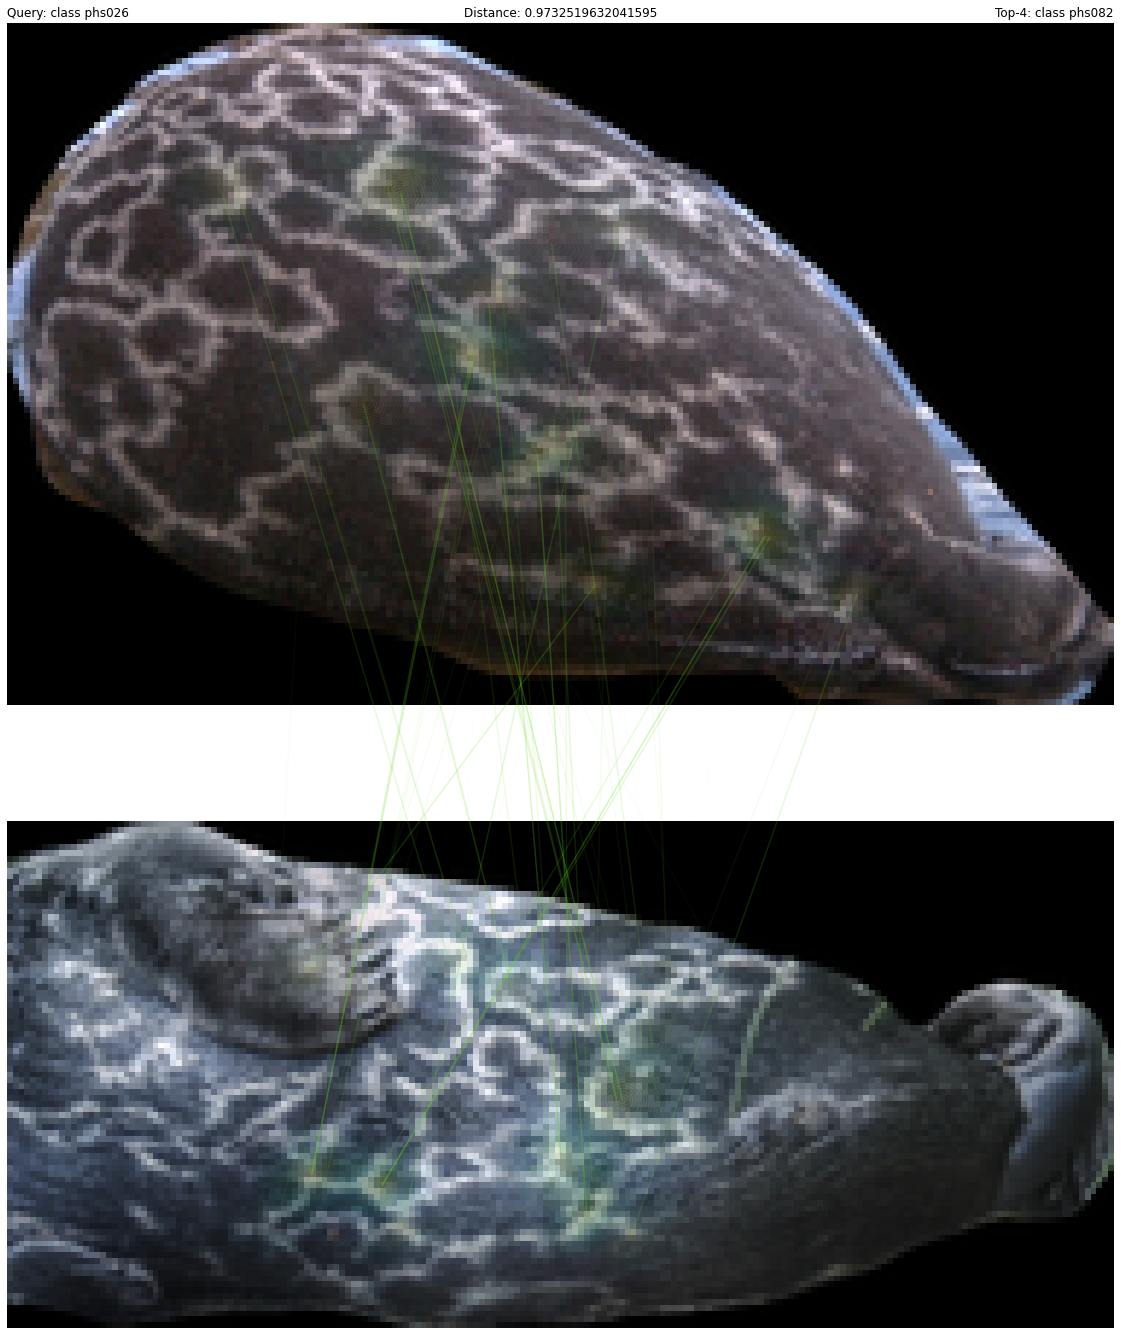

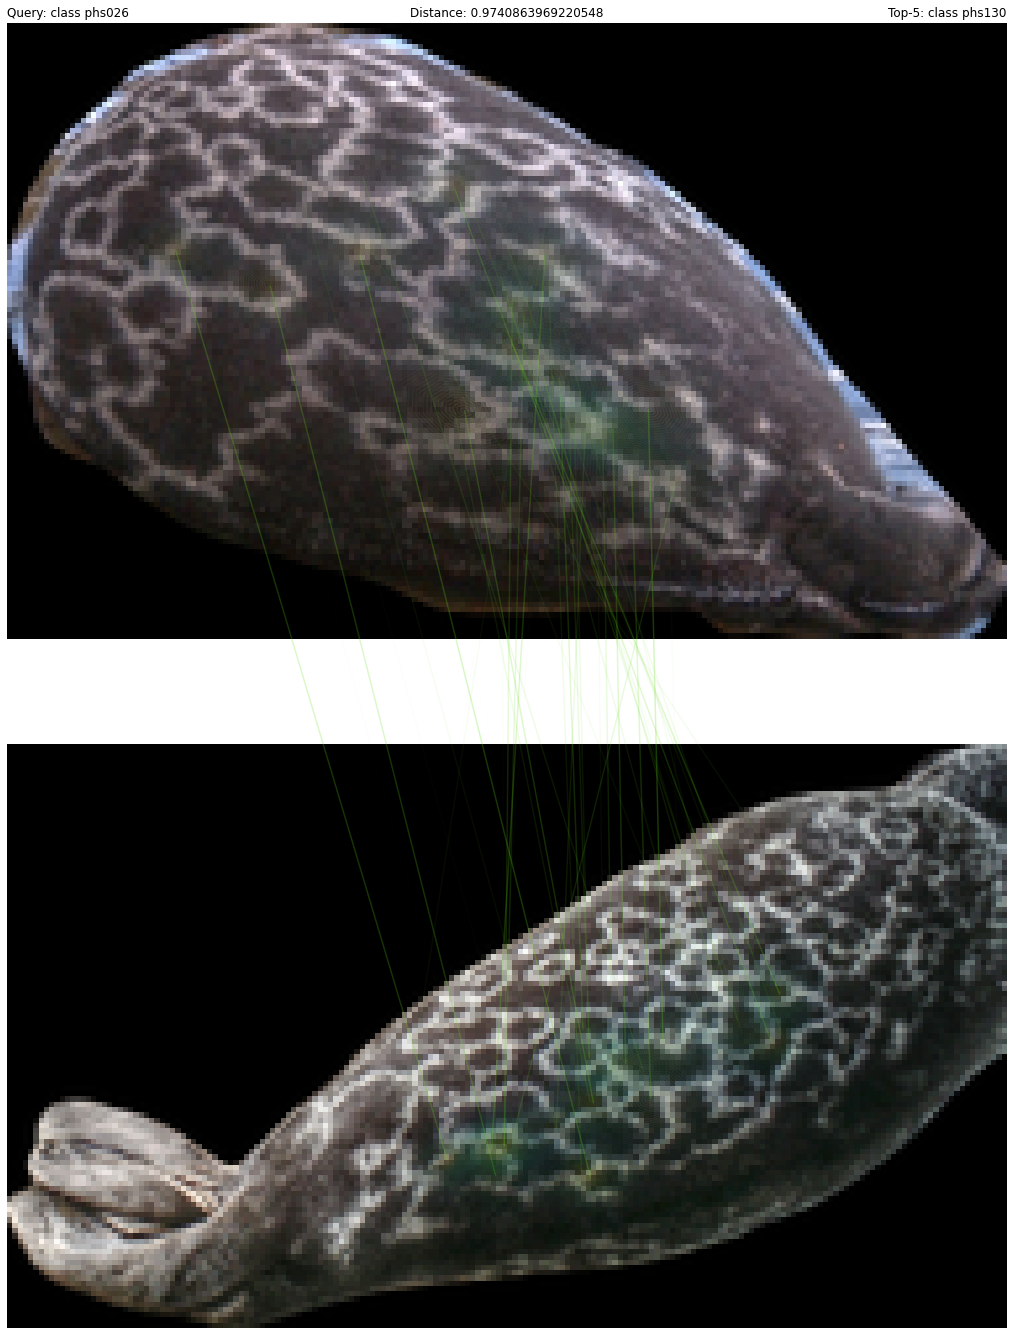

In [86]:
visualise_match(identification_result[0])
print()